# Chapter 5: Paint

## CycleGAN

_Style transfer_ is a machine learning task where a neural network learns to transform instances from one set of data to make it appear to have come from a second set of training instances and vice versa. For example, a style transfer model may transform photos of landscapes to look like they were painted in a particular artist's style.

[_Cycle-consistent adverserial networks_](https://arxiv.org/pdf/1703.10593.pdf) (CycleGAN) is a type of neural network architecture which learns style transfer between two sets of data without the need for paired samples. This is in contrast to previous style transfer networks which required paired samples from either dataset, such as [_pix2pix_](https://arxiv.org/pdf/1611.07004.pdf).

### Model Overview

CycleGANs are composed of two generators and two discriminators. One generator, $G_{AB}$, takes samples from dataset $A$ and transforms it to look like a sample from dataset $B$, the other generator, $G_{BA}$, does the inverse transformation ($B$ to $A$). There are also two discriminators, the first, $D_{A}$, determines if an instance is from dataset $A$ or was transformed by $G_{BA}$ to look like it was sampled from dataset $A$. The other discriminator, $D_B$, determines if samples are from dataset $B$ or were transformed by $G_{AB}$.

## The Generators

Typically the generators are usually using the [_U-Net_](https://arxiv.org/pdf/1505.04597.pdf) or [_ResNet_](https://arxiv.org/pdf/1512.03385.pdf) (residual network) architecture.

### U-Net

The U-Net is similar to a VAE except that it contains _skip connections_ or connections between downsampling and upsampling layers of the same size. U-Net also uses a new type of layer, [instance normalization](https://arxiv.org/pdf/1607.08022.pdf), which works similarly to the batch normalization layer except it normalizes individual observations instead of a batch. Instance normalization does not compute a mean and variance like batch normalization so it does not require a `momentum` parameter.

<img src="https://github.com/shaohua0116/Group-Normalization-Tensorflow/raw/master/figure/gn.png">

A visual demonstraction of the different types of normalization done on CNNs during training visualized in 3-dimensions [[ref]](https://arxiv.org/pdf/1803.08494.pdf). The $H,W$ axis represents the spatial dimensions of the input. The $C$ axis represents the channels (i.e. filters) of the layer, and $N$ represents the "batch axis," i.e. it iterates over each instance in the training batch.

For U-Net, we also omit the scaling and shift parameters in instance normalization, therefore the layer does not learn these parameters during training.

### ResNet

TODO

### Training

In a CycleGAN, we use 3 separate loss functions for the generators:

- _Validity_, do the images lok like they were sampled from the target dataset?

- _Reconstruction_, do images passed through both generators look like the original image?

- _Identity_, if we apply generators to images from their own dataset, is the image unchanged?

## The Discriminators

The discriminators for CycleGAN's do not output a single number, rather they output an 8 by 8 single channel tensor. This is borrowed from _PatchGAN_, a GAN architecture which divides the image into patches and guesses if each patch is real or fake. This helps the discriminator determine if an image is real or fake based on the style rather than the content.

## Setup

In [0]:
!pip install tensorflow-gpu

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import 

## Implementing a CycleGAN

In [0]:
from tensorflow.keras.layers import (Input, Conv2D, Activation, UpSampling2D,
                                     Concatenate, LeakyReLU)
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam


def unet_downsample(layer_input, filters, kernel_size=4,
                    weight_init='glorot_uniform'):
  """Build a downsampling layer of U-Net."""
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2,
             padding='same', kernel_initializer=weight_init)(layer_input)
  x = InstanceNormalization(axis=3, center=False, scale=False)(x)
  return Activation('relu')(x)


def unet_upsample(layer_input, skip_input, filters, kernel_size=4,
                    weight_init='glorot_uniform'):
  """Build an upsampling layer for U-Net."""
  x = UpSampling2D()(layer_input)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=1,
             padding='same', kernel_initializer=weight_init)(x)
  x = InstanceNormalization(axis=-1, center=False, scale=False)(x)
  x = Activation('relu')(x)
  return Concatenate()([x, skip_input])


def build_generator_unet(input_shape, n_filters, channels,
                         weight_init):
    """Build a U-Net generator."""
    x = Input(shape=input_shape)
    d1 = unet_downsample(x, n_filters, weight_init=weight_init)
    d2 = unet_downsample(d1, n_filters << 1, weight_init=weight_init)
    d3 = unet_downsample(d2, n_filters << 2, weight_init=weight_init)
    d4 = unet_downsample(d3, n_filters << 3, weight_init=weight_init)
    u1 = unet_upsample(d4, d3, n_filters << 2, weight_init=weight_init)
    u2 = unet_upsample(u1, d2, n_filters << 1, weight_init=weight_init)
    u3 = unet_upsample(u2, d1, n_filters, weight_init=weight_init)
    u4 = UpSampling2D()(u3)
    output = Conv2D(filters=channels, kernel_size=4, strides=1, padding='same',
                    activation='tanh', kernel_initializer=weight_init)(u4)
    return Model(x, output)


def discriminator_conv_layer(layer_input, filters, strides=2,
                             weight_init='glorot_uniform', normalize=True):
  """Build a 4x4 convolutional layer in the discriminator."""
  x = Conv2D(filters, kernel_size=4, strides=strides,
             padding='same', kernel_initializer=weight_init)(layer_input)
  if normalize:
    x = InstanceNormalization(axis=-1, center=False, scale=False)(x)
  return LeakyReLU(alpha=0.2)(x)


def build_discriminator(input_shape, n_filters, channels,
                        weight_init):
  """Build a discriminator for the CycleGAN."""
  model_input = Input(shape=input_shape)
  x = discriminator_conv_layer(model_input, n_filters, strides=2,
                               weight_init=weight_init, normalize=False)
  x = discriminator_conv_layer(x, n_filters << 1, strides=2,
                               weight_init=weight_init)
  x = discriminator_conv_layer(x, n_filters << 2, strides=2,
                               weight_init=weight_init)
  x = discriminator_conv_layer(x, n_filters << 3, strides=2,
                               weight_init=weight_init)
  model_output = Conv2D(filters=1, kernel_size=4, strides=1, padding='same',
                        kernel_initializer=weight_init)(x)
  return Model(model_input, model_output)


def set_trainable(model, value):
  """Set each layer of a model as trainable."""
  model.trainable = value
  for l in model.layers:
    l.trainable = value


class CycleGAN(object):
  """Cycle-consistent adversarial network implementation."""

  def __init__(self, input_shape, generator_type, generator_n_filters,
               discriminator_n_filters, learning_rate, lambda_validation,
               lambda_reconstruction, lambda_identity):
    # Build the generators.
    weight_init = RandomNormal(mean=0.0, stddev=0.02)
    if generator_type.lower() in ['unet', 'u-net']:
      self.g_AB = build_generator_unet(input_shape, generator_n_filters,
                                       input_shape[2], weight_init)
      self.g_BA = build_generator_unet(input_shape, generator_n_filters,
                                       input_shape[2], weight_init)
    elif generator_type.lower() == 'resnet':
      raise Exception('Not implemented yet')
    else:
      raise Exception('CycleGAN constructed with invalid generator type')
    
    # Build the discriminators.
    self.d_A = build_discriminator(input_shape, discriminator_n_filters,
                                   input_shape[2], weight_init)
    self.d_B = build_discriminator(input_shape, discriminator_n_filters,
                                   input_shape[2], weight_init)

    # Compile the generators.
    set_trainable(self.d_A, False)
    set_trainable(self.d_B, False)

    img_A = Input(shape=input_shape)
    img_B = Input(shape=input_shape)

    fake_B = self.g_AB(img_A)
    fake_A = self.g_BA(img_B)

    reconst_A = self.g_BA(fake_B)
    reconst_B = self.g_AB(fake_A)

    img_A_id = self.g_BA(img_A)
    img_B_id = self.g_AB(img_B)

    valid_A = self.d_A(fake_A)
    valid_B = self.d_B(fake_B)

    self.combined = Model(inputs=[img_A, img_B],
                          outputs=[valid_A, valid_B, reconst_A, reconst_B,
                                   img_A_id, img_B_id])
    self.combined.compile(
        optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
        loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
        loss_weights=[lambda_validation, lambda_validation,
                      lambda_reconstruction, lambda_reconstruction,
                      lambda_identity, lambda_identity])

    set_trainable(self.d_A, True)
    set_trainable(self.d_B, True)

    # Compile the discriminators.
    set_trainable(self.g_AB, False)
    set_trainable(self.g_BA, False)

    self.d_A.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
                     loss=['mse'], metrics=['accuracy'])
    self.d_B.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.5),
                     loss=['mse'], metrics=['accuracy'])

    set_trainable(self.g_AB, True)
    set_trainable(self.g_BA, True)

    patch_size = input_shape[0] / 8
    self.patch_shape = (patch_size, patch_size, 1)

## Changing Pictures of Apples to Oranges (and Vice-Versa) with a CycleGAN

Start by defining constants.

In [0]:
IMAGE_SIZE = 128
BATCH_SIZE = 1

### Downloading the Data

In [1]:
!mkdir data && wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip

--2020-04-13 04:27:39--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  92.6MB/s    in 0.8s    

2020-04-13 04:27:40 (92.6 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [0]:
import zipfile

with zipfile.ZipFile('apple2orange.zip', 'r') as z:
  z.extractall('data/')

In [0]:
import shutil

base_path = 'data/apple2orange/'

for suffix in ['trainA/', 'trainB/', 'testA/', 'testB/']:
  dir_path = base_path + suffix
  os.mkdir(dir_path + 'img/')
  for f in os.listdir(dir_path):
    if 'jpg' in f:
      shutil.move(dir_path + f, dir_path + 'img/' + f)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1.0/255.0)

data_flow_train_A = data_gen.flow_from_directory(
    'data/apple2orange/trainA', target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='input', batch_size=BATCH_SIZE, shuffle=True)
data_flow_train_B = data_gen.flow_from_directory(
    'data/apple2orange/trainB', target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='input', batch_size=BATCH_SIZE, shuffle=True)

Found 995 images belonging to 1 classes.
Found 1019 images belonging to 1 classes.


Let's plot some of the images to get a sense of what the model will be learning from.

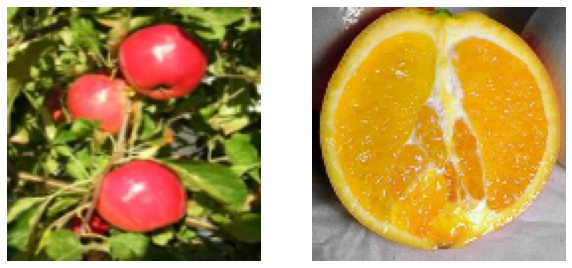

In [44]:
imgA, _ = next(data_flow_train_A)
imgB, _ = next(data_flow_train_B)

fig = plt.figure(figsize=(10, 5))

for i, img in enumerate([imgA[0], imgB[0]]):
  ax = fig.add_subplot(1, 2, i + 1)
  ax.axis('off')
  ax.imshow(img)

### Instantiating the Model

In [0]:
a2o_cyclegan = CycleGAN(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                        generator_type='unet', generator_n_filters=32,
                        discriminator_n_filters=32, learning_rate=0.0002,
                        lambda_validation=1, lambda_reconstruction=10,
                        lambda_identity=2)

In [0]:
a2o_cyclegan.g_AB.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_247 (Conv2D)             (None, 64, 64, 32)   1568        input_52[0][0]                   
__________________________________________________________________________________________________
instance_normalization_200 (Ins (None, 64, 64, 32)   0           conv2d_247[0][0]                 
__________________________________________________________________________________________________
activation_161 (Activation)     (None, 64, 64, 32)   0           instance_normalization_200[0][0] 
___________________________________________________________________________________________

In [0]:
a2o_cyclegan.d_A.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 64, 64, 32)        1568      
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 32, 32, 64)        32832     
_________________________________________________________________
instance_normalization_214 ( (None, 32, 32, 64)        0         
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 16, 16, 128)       131